In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 62kB/s 


In [ ]:
import SimpleITK as sitk 
from tqdm import tqdm
import numpy as np

from keras.utils.np_utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,add,Input,Dropout,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda,PReLU,concatenate
from keras.optimizers import SGD,Adam,RMSprop,Nadam
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras import regularizers
from keras import backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans

#Loading data

In [ ]:
path = './HGG1/'

In [ ]:
def load_data(path):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+p))
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    data.append([flair,t1,t1ce,t2])
    gt.append(seg)
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data,gt

In [ ]:
#HGG
data,gt = load_data(path) 

100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


In [ ]:
data.shape,gt.shape,data.dtype,gt.dtype

((10, 4, 155, 240, 240), (10, 155, 240, 240), dtype('float32'), dtype('uint8'))

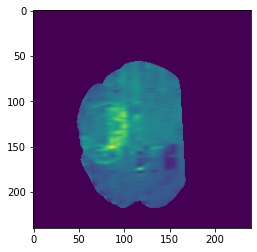

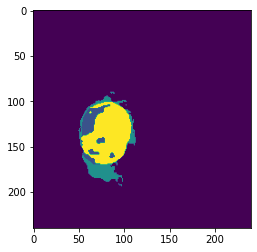

In [ ]:

plt.imshow(data[0,2,65,:,:])
plt.show()
plt.imshow(gt[0,65,:,:])
plt.show()

In [ ]:
data = np.transpose(data,(0,2,3,4,1))

In [ ]:
data.shape,gt.shape,data.dtype,gt.dtype

((10, 155, 240, 240, 4), (10, 155, 240, 240), dtype('float32'), dtype('uint8'))

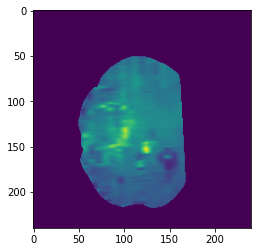

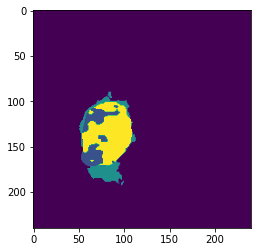

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data[0,70,:,:,2])
plt.show()
plt.imshow(gt[0,70,:,:])
plt.show()

# Pre-Processing

In [ ]:
data.shape,gt.shape

((10, 155, 240, 240, 4), (10, 155, 240, 240))

In [ ]:
data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])   #taking 30-120 slices
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [ ]:
data.shape,gt.shape

((900, 192, 192, 4), (900, 192, 192, 1))

In [ ]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [ ]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((540, 192, 192, 4),
 (540, 192, 192, 4),
 (180, 192, 192, 4),
 (180, 192, 192, 4),
 (180, 192, 192, 4),
 (180, 192, 192, 1))

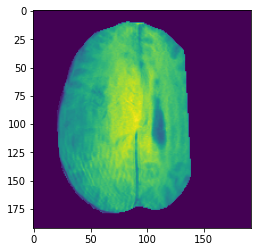

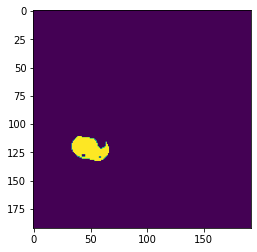

In [ ]:
plt.imshow(X_train[0,:,:,1])
plt.show()
plt.imshow(Y_train[0,:,:,1])
plt.show()

In [ ]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((540, 192, 192, 4),
 (540, 192, 192, 4),
 (180, 192, 192, 4),
 (180, 192, 192, 4))

## 2D-VNet model


In [ ]:

def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
  

In [ ]:
def resBlock(conv,stage,keep_prob,stage_num=5):
    inputs=conv
    
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([inputs,conv]))
    conv_drop=Dropout(keep_prob)(conv_add)
    
    if stage<stage_num:
        conv_downsample=PReLU()(BatchNormalization()(Conv2D(16*(2**stage), 2, strides=(2, 2),activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv_drop)))
        return conv_downsample,conv_add
    else:
        return conv_add,conv_add
        
def up_resBlock(forward_conv,input_conv,stage):
    conv=concatenate([forward_conv,input_conv],axis = -1)
  
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([input_conv,conv]))
    if stage>1:
        conv_upsample=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(stage-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

def vnet(pretrained_weights = None,input_size = (192,192,4),num_class=1,is_training=True,stage_num=5,thresh=0.5):
    keep_prob = 0.1
    features=[]
    input_model = Input(input_size)
    x=PReLU()(BatchNormalization()(Conv2D(16, 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(input_model)))
    
    for s in range(1,stage_num+1):
        x,feature=resBlock(x,s,keep_prob,stage_num)
        features.append(feature)
        
    conv_up=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(s-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(x)))
    
    for d in range(stage_num-1,0,-1):
        conv_up=up_resBlock(features[d-1],conv_up,d)
    if num_class>1:
        conv_out=Conv2D(num_class, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    else:
        conv_out=Conv2D(num_class, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    
    
    
    
    model=Model(inputs=input_model,outputs=conv_out)    

    model.compile(optimizer = Nadam(lr = 2e-4),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model
model=vnet(input_size = (192,192,4),num_class=4,stage_num=5)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 192, 192, 16) 589824      batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
checkpointer = callbacks.ModelCheckpoint(filepath = 'vnet-weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[training_log,checkpointer],shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
68/68 [==============================] - 83s 291ms/step - loss: 0.3468 - dice_coef: 0.6532 - accuracy: 0.6863 - val_loss: 0.3244 - val_dice_coef: 0.6756 - val_accuracy: 0.9016
Epoch 2/30
68/68 [==============================] - 13s 193ms/step - loss: 0.0869 - dice_coef: 0.9131 - accuracy: 0.9539 - val_loss: 0.1316 - val_dice_coef: 0.8684 - val_accuracy: 0.9700
Epoch 3/30
68/68 [==============================] - 13s 195ms/step - loss: 0.0460 - dice_coef: 0.9540 - accuracy: 0.9718 - val_loss: 0.0860 - val_dice_coef: 0.9140 - val_accuracy: 0.9695
Epoch 4/30
68/68 [==============================] - 13s 197ms/step - loss: 0.0357 - dice_coef: 0.9643 - accuracy: 0.9744 - val_loss: 0.0552 - val_dice_coef: 0.9448 - val_accuracy: 0.9713
Epoch 5/30
68/68 [==============================] - 13s 198ms/step - loss: 0.0293 - dice_coef: 0.9707 - accuracy: 0.9775 - val_loss: 0.0370 - val_dice_coef: 0.9630 - val_accuracy: 0.9757
Epoch 6/30
68/68 [==============================] - 13s 196ms/ste

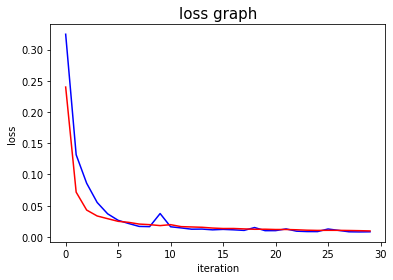

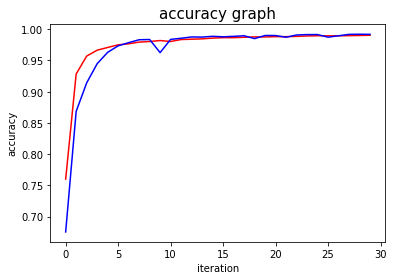

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()



In [ ]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

In [ ]:
np.unique(Y_pre)

array([0, 2, 3])

In [ ]:
Y_pre.shape

(180, 192, 192)

In [ ]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [ ]:
Y_test.shape,X_test.shape

((180, 192, 192, 1), (180, 192, 192, 4))

X_test 0


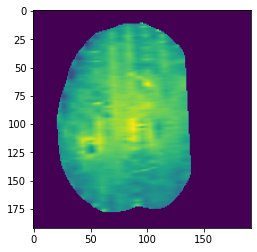

Predicted 0


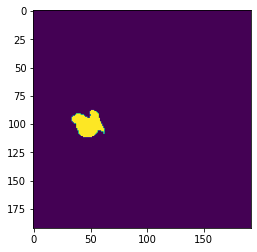

Actual 0


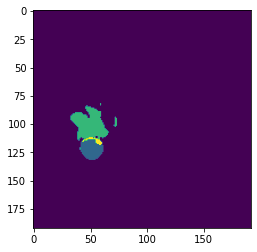

X_test 1


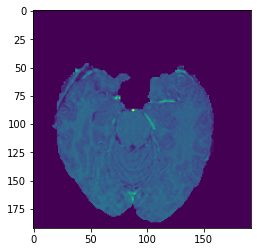

Predicted 1


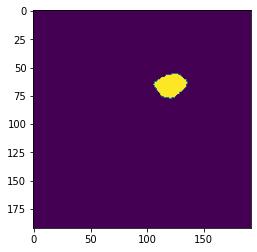

Actual 1


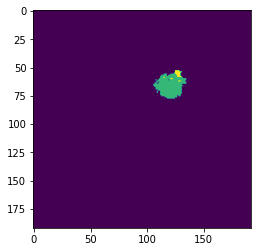

X_test 2


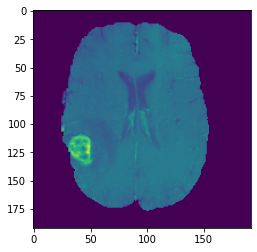

Predicted 2


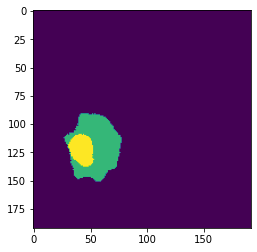

Actual 2


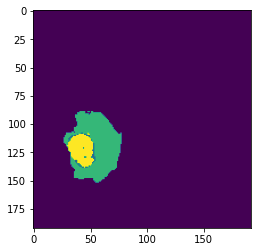

X_test 3


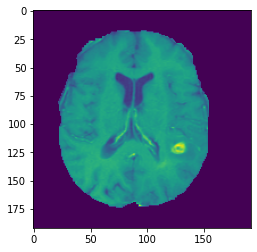

Predicted 3


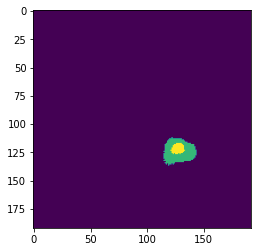

Actual 3


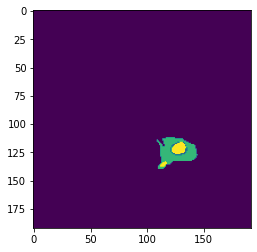

X_test 4


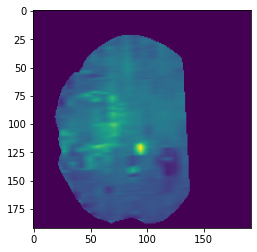

Predicted 4


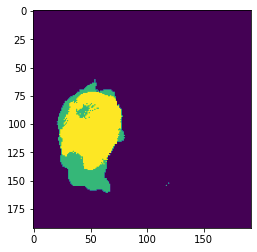

Actual 4


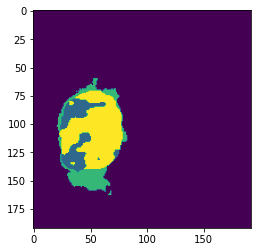

In [ ]:
for i in range(5):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [ ]:
Y_test_encod = to_categorical(Y_test)

In [ ]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

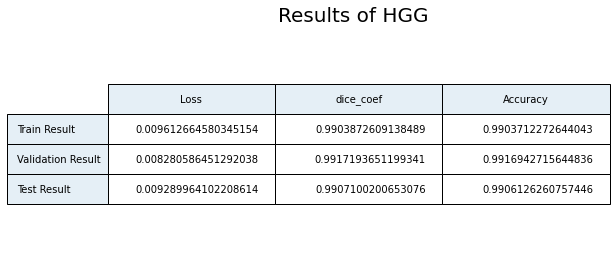

In [ ]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [ ]:
model.save('vnet-model.h5',overwrite=True)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
